In [12]:
import time
from collections import defaultdict
import json
import math
import random
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LarsCV, LassoCV, LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import xgboost as xgb
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

In [3]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

## Quick test for one model

In [41]:
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
scoring = 'neg_mean_squared_error'

model = Lasso()
rbg_scores = cross_val_score(
    model,       
    X_all.loc[rbg_cols],  
    y_ogtt.loc[rbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

fbg_scores = cross_val_score(
    model,       
    X_all.loc[fbg_cols],  
    y_ogtt.loc[fbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

## parameters for big result 

In [116]:
# Lasso and Ridge alpha parameters were found from using their cross validators in another notebook

n_repeats, n_splits = 200, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
models = {
    'ols': (LinearRegression(), X_scaled),
    'lasso': (Lasso(alpha=483), X_scaled),
    'ridge': (Ridge(alpha=0.1), X_scaled),
    'svm': (SVR(kernel='linear', C=128), X_scaled),
    'pls': (PLSRegression(), X),
    'rf': (RandomForestRegressor(n_estimators=200, max_features=100, random_state=42), X),
}
y = {
    'ogtt': y_ogtt,
    'insulin': y_insulin,
    'weight': y_weight,
}

In [117]:
results = {}
for y_name, y_data in y.items(): 
    results[y_name] = {}
    for model_name, (model, x_data) in models.items():
        results[y_name][model_name] = {}
        for bg_type, bg_cols in [('Fed', rbg_cols), ('Fasted', fbg_cols)]:
            print(y_name, model_name, bg_type)
            results[y_name][model_name][bg_type] = \
            cross_validate(
                estimator=model, 
                X=x_data.loc[bg_cols], 
                y=y_data.loc[bg_cols], 
                cv=cv, 
                n_jobs=7,
                scoring=scoring,
                return_estimator=True,)

ogtt ols Fed
ogtt ols Fasted
ogtt lasso Fed
ogtt lasso Fasted
ogtt ridge Fed
ogtt ridge Fasted
ogtt svm Fed
ogtt svm Fasted
ogtt pls Fed
ogtt pls Fasted
ogtt rf Fed
ogtt rf Fasted
insulin ols Fed
insulin ols Fasted
insulin lasso Fed
insulin lasso Fasted
insulin ridge Fed
insulin ridge Fasted
insulin svm Fed
insulin svm Fasted
insulin pls Fed
insulin pls Fasted
insulin rf Fed
insulin rf Fasted
weight ols Fed
weight ols Fasted
weight lasso Fed
weight lasso Fasted
weight ridge Fed
weight ridge Fasted
weight svm Fed
weight svm Fasted
weight pls Fed
weight pls Fasted
weight rf Fed
weight rf Fasted


In [118]:
# with open(r'../data/interim/model_fasted_vs_fed_results.csv', 'w') as f:
#     w = csv.writer(f)
#     w.writerow(header)

all_rows = []
#     scoring_dict = {}
#     dfs_list = []
for y_name, y_result in results.items():
#         scoring_dict[y_name] = {}
    for model_name, model_result in results[y_name].items():
#             scoring_dict[y_name][model_name] = {}
        for i, (bg_type, bg_result) in enumerate(model_result.items()):
#             print(model_name, bg_type)
#                 scoring_dict[y_name][model_name][bg_type] = {}
            result_list = [y_name, model_name, bg_type]
            importances = []
            for j, est in enumerate(bg_result['estimator']):
#                     print(j)
                if model_name == 'rf' or model_name == 'xgboost': 
                    importances.append(est.feature_importances_)
                elif model_name == 'svm':
                    importances.append(est.coef_[0])
                elif model_name == 'pls':
                    importances.append(est.coef_.T[0])
                else:
                    importances.append(est.coef_)
            result_list.extend(np.mean(importances, axis=0))

#                     df = pd.DataFrame(bg_list, columns=est.feature_names_in_).mean()
#                     df['y_name'], df['model_name'], df['bg_type'] = y_name, model_name, bg_type
#                 display(df)
#                 dfs[y_name][model_name][bg_type] = df
#                     dfs_list.append(df)
            for score in scoring:
#                 scoring_dict[y_name][model_name][bg_type][score] = bg_result['test_' + score]
                result_list.extend(bg_result['test_' + score])
#                 w.writerow(result_list)
            all_rows.append(result_list)

In [123]:
header = ['y', 'model', 'x']
header.extend(data.index)
header.extend([score + f'_{x:04}' for score in scoring for x in range(n_repeats * n_splits)])

r = pd.DataFrame(all_rows, columns=header)
score_cols = r.filter(regex='neg_').columns
r.loc[:, score_cols] = -1 * r.loc[:, score_cols]

for i, score in enumerate(scoring, start=3):
    cols = r.filter(regex=score).columns
    r.insert(loc=i, value=r[cols].mean(axis=1), column=score + '_mean')
    r.insert(loc=i, value=r[cols].median(axis=1), column=score + '_median')

# r.to_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv')

r

,y,model,x,neg_mean_squared_error_median,r2_median,neg_mean_absolute_percentage_error_median,neg_root_mean_squared_error_median,neg_root_mean_squared_error_mean,neg_mean_absolute_percentage_error_mean,r2_mean,...,neg_root_mean_squared_error_0990,neg_root_mean_squared_error_0991,neg_root_mean_squared_error_0992,neg_root_mean_squared_error_0993,neg_root_mean_squared_error_0994,neg_root_mean_squared_error_0995,neg_root_mean_squared_error_0996,neg_root_mean_squared_error_0997,neg_root_mean_squared_error_0998,neg_root_mean_squared_error_0999
0,ogtt,ols,Fed,3.412391e+07,0.756484,0.135754,5841.564391,5943.636948,0.144104,0.636585,...,4659.836070,6573.206889,5299.377989,5315.699842,6411.417168,3452.688462,7646.250768,8058.565474,3871.398295,7012.432645
1,ogtt,ols,Fasted,5.144212e+07,0.631656,0.168154,7172.315421,7352.169562,0.176254,0.537024,...,8666.976833,6916.727059,5718.269852,10272.929095,7967.187693,13179.586632,8558.311831,6597.852282,11187.044669,6159.096970
2,ogtt,lasso,Fed,4.048543e+07,0.695453,0.145857,6362.816320,6577.032770,0.159265,0.572077,...,5104.337756,8064.986152,6481.590447,6043.037732,7390.958394,5705.554325,8910.750695,10569.768316,4848.155966,7414.556512
3,ogtt,lasso,Fasted,5.785304e+07,0.588444,0.178802,7606.116821,7729.922147,0.189204,0.492115,...,8818.258012,6839.529769,7408.779170,7403.384773,8423.609225,11201.161940,8361.270402,11315.915023,12621.904284,6749.589105
4,ogtt,ridge,Fed,3.412736e+07,0.756469,0.135746,5841.859473,5943.697066,0.144103,0.636572,...,4660.114473,6573.775168,5299.128099,5315.655445,6412.033686,3452.962060,7646.562519,8059.007583,3871.975516,7011.989181
5,ogtt,ridge,Fasted,5.154653e+07,0.633363,0.167394,7179.591306,7344.789148,0.176131,0.537397,...,8710.763984,6606.830207,5626.483070,11533.816786,7967.997199,13526.314046,8558.361624,6596.675592,11187.337821,5879.278590
6,ogtt,svm,Fed,3.412396e+07,0.756486,0.135753,5841.568466,5943.510314,0.144098,0.636591,...,4659.827189,6573.203953,5299.347069,5315.691701,6411.437797,3452.684068,7646.267462,8058.603002,3871.424727,7012.388151
7,ogtt,svm,Fasted,5.154757e+07,0.633385,0.167391,7179.663765,7344.670457,0.176128,0.537404,...,8710.907662,6606.409201,5626.781684,11534.189224,7967.196560,13526.949294,8558.310666,6596.481633,11187.043557,5879.006986
8,ogtt,pls,Fed,4.495012e+07,0.679184,0.157703,6704.483938,6794.948600,0.164465,0.526279,...,4234.416338,7831.576029,5388.973128,5529.082301,8570.170247,3220.003269,9069.276253,9252.397483,5772.780937,8389.896187
9,ogtt,pls,Fasted,4.985804e+07,0.649602,0.159438,7061.022232,7275.078906,0.168281,0.534227,...,8920.909294,6942.894667,4735.633015,10205.653393,9252.422630,11366.221592,7782.703897,5559.203522,11813.739721,7186.879474


In [181]:
ranks = r.loc[(r['y'] == 'ogtt') \
              & (~r['model'].isin(['lasso'])),  # Dropping LASSO justifiable because only 251/1371 features 
                                                #    are nonzero, which messes up the rankings 
              data.index].abs().rank(axis=1, ascending=False)
# display(ranks)
avg_rank = ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fed')].mean().sort_values().to_frame('Fed')

avg_rank = avg_rank.join(ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fasted')].mean().to_frame('Fasted'))
avg_rank = avg_rank.join(data[['qval_fed', 'qval_fasted', 'ID']])
avg_rank.loc[:, ['qval_fed', 'qval_fasted']] = avg_rank.loc[:, ['qval_fed', 'qval_fasted']].rank(ascending=True)
ids_ranks = avg_rank.loc[avg_rank['ID'] != 'unknown']
ids_ranks.iloc[:50]

,Fed,Fasted,qval_fed,qval_fasted,ID
i,,,,,
l_393,18.0,794.8,24.5,1170.5,SM d37:1
l_604,48.2,236.8,12.5,139.0,TG 18:1_22:6_22:6
l_159,51.8,698.0,186.5,852.5,SM d36:3
l_461,51.8,24.4,128.0,35.0,Plasmanyl-PC O-20:0_20:4
l_150,55.6,591.6,449.5,835.0,PC 38:7
l_567,63.2,273.0,9.0,32.0,TG 18:2_22:6_22:6
m_227,70.8,625.2,672.5,1061.0,Ascorbic acid 2-sulfate
l_538,77.2,148.0,7.0,6.0,TG 22:6_22:6_22:6
l_425,80.2,802.8,313.0,1367.5,SM d38:1


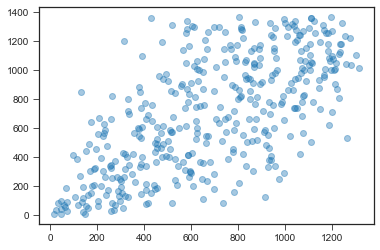

In [187]:
plt.scatter(ids_ranks['Fasted'], ids_ranks['qval_fasted'], alpha=0.4)

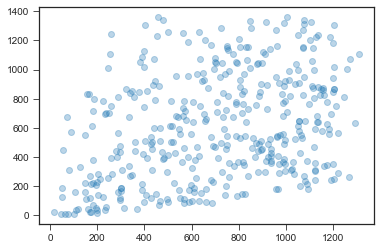

In [184]:
plt.scatter(ids_ranks['Fed'], ids_ranks['qval_fed'], alpha=0.3)

In [36]:
for y_name, y_result in results.items():
    for model_name, model_result in y_result.items():
        

{'ols': {'fit_time': array([0.10006166, 0.08066344, 0.14572406, 0.09044433, 0.09020853,
       0.1520164 , 0.16162086, 0.17377853, 0.05445051, 0.05692029,
       0.04694867, 0.04501009, 0.04642653, 0.03845954, 0.05789471,
       0.05983496, 0.03490615, 0.04288578, 0.03789258, 0.04088759]), 'score_time': array([0.05260324, 0.04296994, 0.04847598, 0.04012036, 0.04947281,
       0.0629456 , 0.05756211, 0.04586744, 0.05792403, 0.04947042,
       0.05242109, 0.04088235, 0.03990126, 0.06781912, 0.04786658,
       0.04089308, 0.04188776, 0.02692747, 0.03091669, 0.03091764]), 'estimator': [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()], 'test_neg_

In [ ]:
#     'xgboost': (xgb.XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=100, random_state=1), X)
